<a href="https://colab.research.google.com/github/hiyori99/Colaboratory/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from sklearn.datasets import make_blobs # ダミーデータの生成用
X, y = make_blobs(n_samples=500, centers=4, random_state=8, cluster_std=2.4)
# n_samples:サンプル数 centers:中心点の数 random_state:seed値 cluster_std: ばらつき度合い

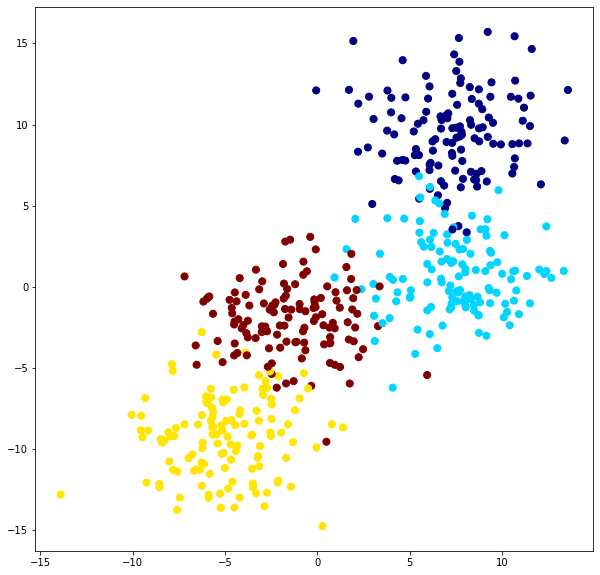

In [17]:
plt.figure(figsize =(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')

In [18]:
!pip install visualize

In [19]:
#結果を可視化する関数

# 決定木を描画してみる
def visualize_tree(classifier, X, y, boundaries=True,xlim=None, ylim=None):
    """決定木の可視化関数。
    INPUTS: 分類モデル, X, y, optional x/y limits.
    OUTPUTS: Meshgridを使った決定木の可視化
    """
    # fitを使ったモデルの構築
    classifier.fit(X, y)

    # 軸を自動調整
    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim


    # meshgridをつくる。
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),np.linspace(y_min, y_max, 100))

    # 分類器の予測を実行
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # meshgridを使って整形。
    Z = Z.reshape(xx.shape)

    # 分類ごとに色付け。
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='jet')

    # 訓練データの描画。
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        

    def plot_boundaries(i, xlim, ylim):
        '''
        境界線を描き込みます。
        '''
        if i < 0:
            return

        tree = classifier.tree_

        # 境界を描画するために、再帰的に呼び出します。
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i], [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i], [tree.threshold[i], xlim[1]], ylim)

        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])

    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

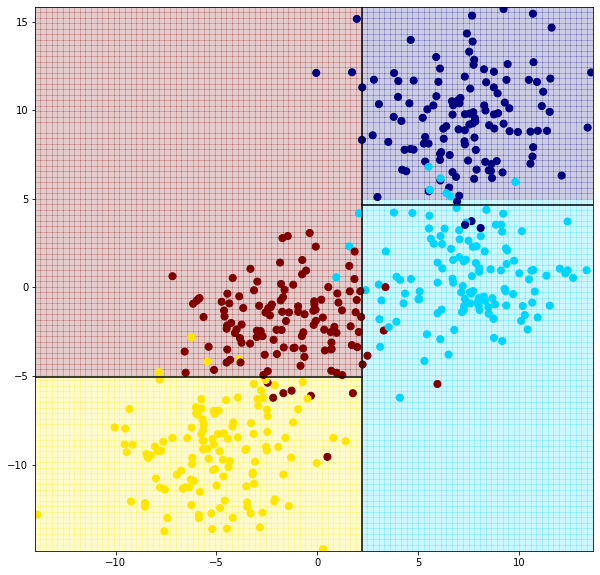

In [21]:
from sklearn.tree import DecisionTreeClassifier             # 決定木用
clf = DecisionTreeClassifier(max_depth=2, random_state = 0) # インスタンス作成 max_depth:木の深さ
visualize_tree(clf, X, y)    # 描画実行

直線を使って、4つに分類できている様子がわかる。

決定木の深さ(max_depth)の数で、精度が変わるので、max_depthを4にしてやってみると、以下になる。

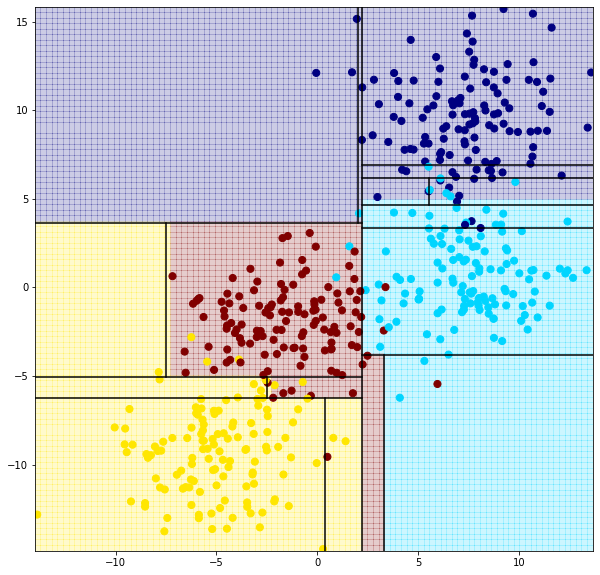

In [20]:
clf2 = DecisionTreeClassifier(max_depth=4, random_state = 0) # インスタンス作成 max_depth:木の深さ
visualize_tree(clf2, X, y)    # 描画実行

深さ2より、細かい分類をしようとしている様子が見て取れる。

しかし、深さを多くすればするほど、学習データに対する精度が高くなるが、過学習しやすくなってしまう。
これを回避するために、ランダムフォレストを実行する。

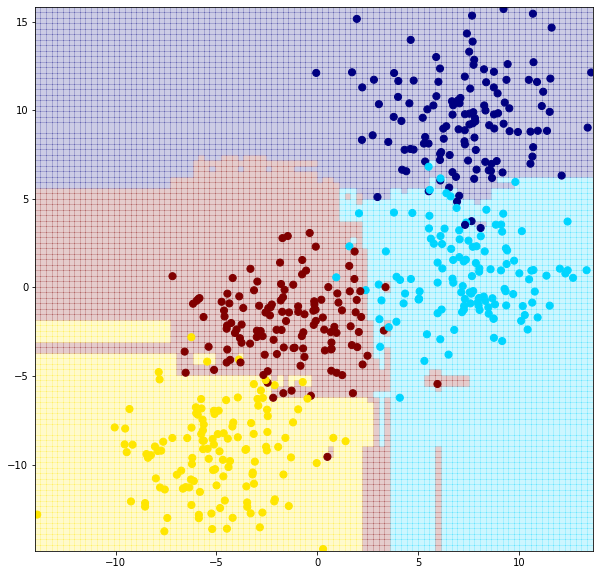

In [11]:
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト用
clf = RandomForestClassifier(n_estimators=100, random_state=0) # インスタンス作成　n_estimators:作る決定木の数の指定
visualize_tree(clf, X, y, boundaries=False)

分類が単純な直線ではなく、決定木1個よりは精度がたかそうな様子がわかる。
ちなみに、これをやれば必ず過学習が防げるわけではなく、例えば上の図の右下の赤丸は外れ値的な気がするけど、これを赤とグルーピングしている。

<ErrorbarContainer object of 3 artists>

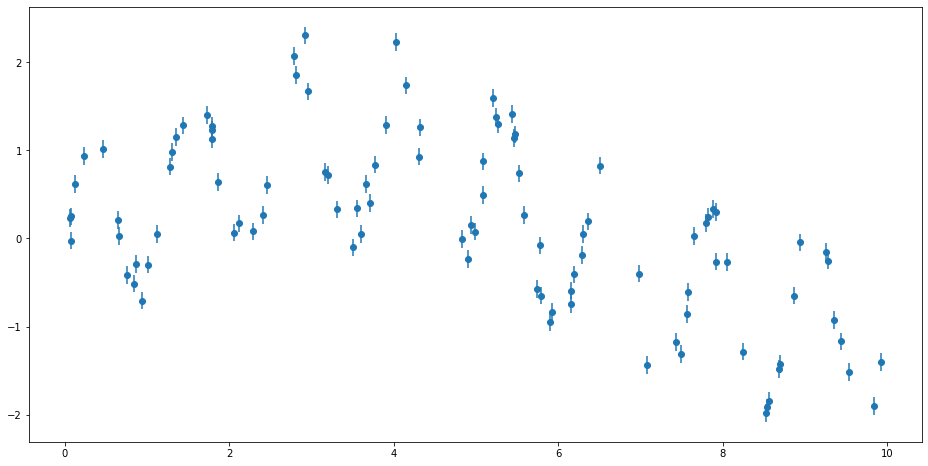

In [12]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def sin_model(x, sigma=0.2):
    """大きな波＋小さな波＋ノイズからなるダミーデータ。"""
    noise = sigma * np.random.randn(len(x))

    return np.sin(5 * x) + np.sin(0.5 * x) + noise

# xからyを計算
y = sin_model(x)

# Plotしてみる。
plt.figure(figsize=(16,8))
plt.errorbar(x, y, 0.1, fmt='o')

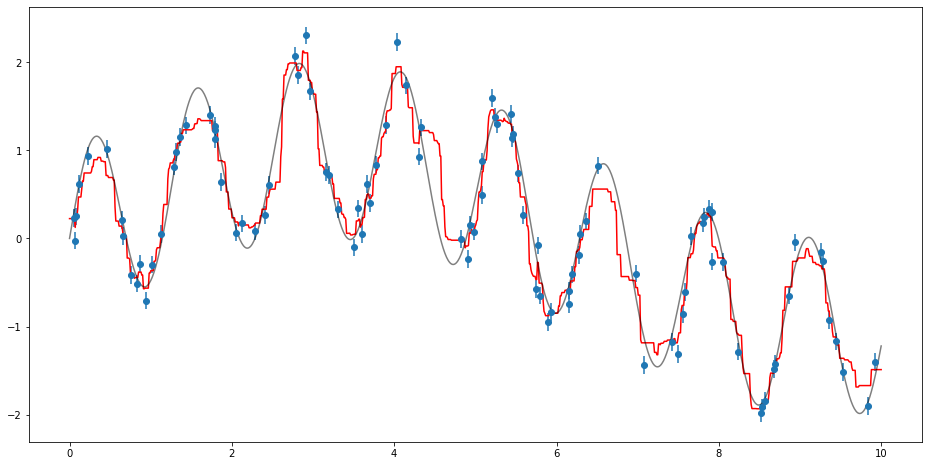

In [13]:
from sklearn.ensemble import RandomForestRegressor # ランダムフォレスト回帰用

# 確認用に0〜10の1000個のデータを用意
xfit = np.linspace(0, 10, 1000)       #0〜10まで1000個

# ランダムフォレスト実行
rfr = RandomForestRegressor(100)  # インスタンスの生成　木の数を100個に指定
rfr.fit(x[:, None], y)            # 学習実行
yfit = rfr.predict(xfit[:, None]) # 予測実行

# 結果比較用に実際の値を取得。
ytrue = sin_model(xfit,0) # xfitを波発生関数に食わせて、その結果を取得

# 結果確認
plt.figure(figsize = (16,8))
plt.errorbar(x, y, 0.1, fmt='o')
plt.plot(xfit, yfit, '-r')                # 予測値のplot
plt.plot(xfit, ytrue, '-k', alpha = 0.5)  # 正解値のplot

赤線が予測の回帰線で、そこそこ良さそうな結果になってることがわかる。